## This notebook is deprecated in favor of more general MAGMA-seq analysis

# Binary Classification Analysis for Kirby et al. (2025) Data

This notebook analyzes antibody sequences from Kirby et al. "Retrospective SARS-CoV-2 human antibody development trajectories are largely sparse and permissive" PNAS 2025.

## Data Generation

To generate all required data files for this analysis, run the complete workflow script:

```bash
# From project root, with netam virtual environment activated
./scripts/kirby_complete_workflow.sh
```

This script runs the complete pipeline including model scoring, UCA analysis, and random mutant generation.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import sys
sys.path.append('../../')
from dnsmex.local import localify
from dnsmex.kirby_helper import KirbyBinaryPartition

# Set up plotting
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

figures_dir = localify("FIGURES_DIR")

## Setup and Data Loading

In [2]:
# Load data and cached model scores
partition_summary = pd.read_csv(localify("DATA_DIR/whitehead/kirby/uca_baseline_partitions/uca_baseline_summary.csv"))
binary_path = "../../_output/kirby_kd_based_binary.csv"
binary_df = pd.read_csv(binary_path)

print("=== DATASET OVERVIEW ===")
print(f"Total sequences: {len(binary_df)}")
print(f"KD threshold (median): {binary_df['KD_continuous'].median():.1f} nM")
print(f"Binders (top 50%): {(binary_df['binary_label'] == 1).sum()}")
print(f"Non-binders (bottom 50%): {(binary_df['binary_label'] == 0).sum()}")
print()

print("Antibody lineages:")
print(partition_summary[['antibody', 'variant_count']].to_string(index=False))
print()

# Load cached model scores for each antibody lineage
antibodies = ['UCA_2-15', 'UCA_002-S21F2', 'UCA_C118']
all_partitions = {}

for antibody in antibodies:
    score_file = f"../../_output/{antibody}_model_scores.csv"
    scores_df = pd.read_csv(score_file)
    partition = KirbyBinaryPartition(antibody=antibody, df=scores_df)
    partition.load_binary_labels(binary_path)
    all_partitions[antibody] = partition

print("✅ Loaded model scores:")
for antibody in antibodies:
    n_seqs = len(all_partitions[antibody].df.drop_duplicates(['VH', 'VL']))
    print(f"  {antibody}: {n_seqs} sequences")

models = ['dasm', 'dasm_ft_mild', 'esm', 'ablang', 'progen']

=== DATASET OVERVIEW ===
Total sequences: 550
KD threshold (median): 34.0 nM
Binders (top 50%): 275
Non-binders (bottom 50%): 275

Antibody lineages:
     antibody  variant_count
     UCA_2-15            401
UCA_002-S21F2             97
     UCA_C118             52

Using KD-based binary classification from ../../_output/kirby_kd_based_binary.csv
Using KD-based binary classification from ../../_output/kirby_kd_based_binary.csv
Using KD-based binary classification from ../../_output/kirby_kd_based_binary.csv
✅ Loaded model scores:
  UCA_2-15: 401 sequences
  UCA_002-S21F2: 97 sequences
  UCA_C118: 52 sequences


## Results

### Per-Lineage Model Performance vs. Binding Affinity

The scatter plots below show the relationship between each model's predictions and experimentally measured binding affinity (-log₁₀ KD) for each antibody lineage. Red points indicate lower affinity binders, green points indicate higher affinity binders (determined by the median KD within each lineage). Dashed vertical lines show the top-K selection thresholds.

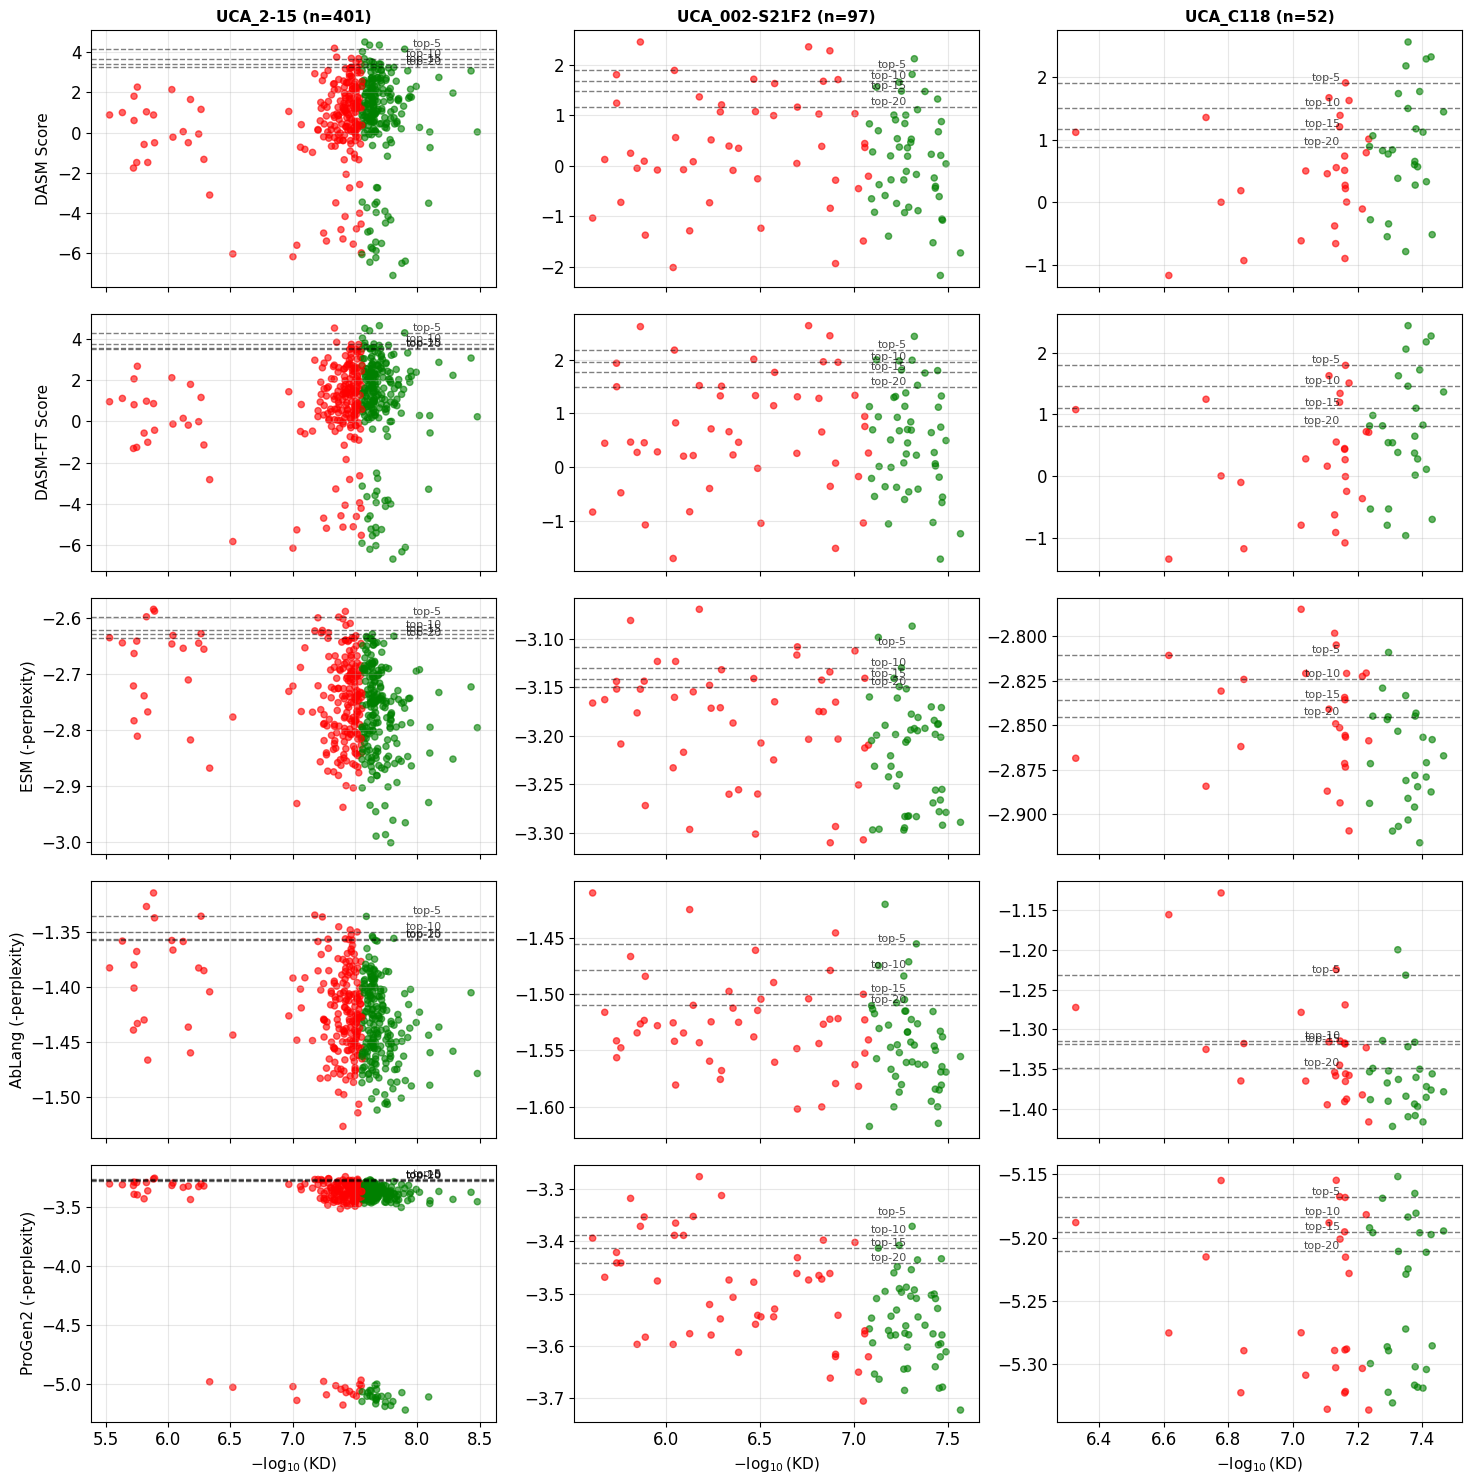

In [3]:
# Create per-lineage scatter plots
fig, axes = plt.subplots(len(models), len(antibodies), figsize=(15, 15), sharex='col')

for i, model in enumerate(models):
    for j, antibody in enumerate(antibodies):
        ax = axes[i, j]
        partition = all_partitions[antibody]
        data = partition.df.drop_duplicates(subset=['VH', 'VL'], keep='first')
        
        # Color by binary label (top 50% affinity per lineage)
        kd_median = data['KD_continuous'].median()
        colors = ['red' if kd > kd_median else 'green' for kd in data['KD_continuous']]
        
        # Scatter plot with flipped axes: KD on x-axis, model predictions on y-axis
        ax.scatter(data['-log10_KD'], data[model], c=colors, alpha=0.6, s=20)
        
        # Add top-K horizontal lines (per lineage) - now horizontal since model is on y-axis
        model_sorted = data.sort_values(model, ascending=False)
        for k in [5, 10, 15, 20]:
            if k <= len(data):
                kth_score = model_sorted.iloc[k-1][model]
                ax.axhline(kth_score, color='black', linestyle='--', alpha=0.5, linewidth=1)
                ax.text(ax.get_xlim()[1]*0.95, kth_score, f'top-{k}', 
                       rotation=0, ha='right', va='bottom', fontsize=8, alpha=0.7)
        
        # Calculate and display correlation
        # corr, p_val = pearsonr(data['-log10_KD'], data[model])
        # ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, 
        #        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        #        verticalalignment='top', fontsize=10)
        
        # Labels and title
        if i == 0:
            # Single line column titles
            ax.set_title(f'{antibody} (n={len(data)})', fontsize=11, fontweight='bold')
        
        # X-axis label on bottom row only
        if i == len(models) - 1:
            ax.set_xlabel(r'$-\log_{10}$(KD)', fontsize=11)
        
        # Y-axis label on left column with model-specific labels
        if j == 0:
            model_label = model.upper()
            if model == 'dasm':
                y_label = 'DASM Score'
            elif model == 'dasm_ft_mild':
                y_label = 'DASM-FT Score'
            elif model == 'esm':
                y_label = 'ESM (-perplexity)'
            elif model == 'ablang':
                y_label = 'AbLang (-perplexity)'
            elif model == 'progen':
                y_label = 'ProGen2 (-perplexity)'
            ax.set_ylabel(y_label, fontsize=11)
        
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{figures_dir}/kirby_binary_scatter.svg", bbox_inches='tight')
plt.show()

### Enrichment Analysis: Model Performance vs. Random Selection

This analysis quantifies how much better each model performs compared to random selection (50% baseline) across different values of K (top-5, top-10, top-20). Values above 1.0 indicate better-than-random performance.

In [4]:
# Calculate per-lineage performance metrics
performance_data = []

for antibody in antibodies:
    partition = all_partitions[antibody]
    data = partition.df.drop_duplicates(subset=['VH', 'VL'], keep='first')
    
    # Calculate random baseline (50% for per-lineage analysis)
    random_precision = 0.5
    
    for model in models:
        # Top-K precision (per lineage)
        kd_median = data['KD_continuous'].median()
        high_affinity = data['KD_continuous'] <= kd_median
        
        model_sorted = data.sort_values(model, ascending=False)
        
        for k in [5, 10, 15, 20]:
            if k <= len(data):
                top_k_seqs = model_sorted.head(k)
                top_k_high_affinity = (top_k_seqs['KD_continuous'] <= kd_median).sum()
                precision = top_k_high_affinity / k
                enrichment = precision / random_precision  # Enrichment over random
                
                performance_data.append({
                    'antibody': antibody,
                    'model': model,
                    'k': k,
                    'precision': precision,
                    'enrichment': enrichment,
                    'n_sequences': len(data)
                })

perf_df = pd.DataFrame(performance_data)

print("Enrichment over random (50% baseline):")
print(perf_df.pivot_table(index=['antibody', 'model'], 
                         columns='k', 
                         values='enrichment', 
                         aggfunc='first').round(2))

Enrichment over random (50% baseline):
k                            5    10    15   20
antibody      model                            
UCA_002-S21F2 ablang        0.8  0.8  0.67  0.7
              dasm          0.4  0.4  0.80  0.7
              dasm_ft_mild  0.4  0.8  0.80  0.8
              esm           0.8  0.6  0.53  0.5
              progen        0.0  0.2  0.40  0.5
UCA_2-15      ablang        0.4  0.2  0.53  0.5
              dasm          1.6  1.2  1.33  1.4
              dasm_ft_mild  1.6  1.4  1.47  1.5
              esm           0.0  0.0  0.13  0.3
              progen        0.0  0.2  0.13  0.3
UCA_C118      ablang        0.8  0.6  0.53  0.6
              dasm          1.6  1.4  1.20  1.2
              dasm_ft_mild  1.6  1.4  1.20  1.3
              esm           0.4  0.2  0.40  0.7
              progen        0.8  1.0  0.93  1.1


In [5]:
# Prepare data for plotting - using colorblind-friendly palette
k_values = [5, 10, 15, 20]
colors = {'dasm': '#0173b2', 'dasm_ft_mild': '#0173b2', 'esm': '#029e73', 'ablang': '#cc78bc', 'progen': '#d55e00'}
linestyles = {'dasm': '-', 'dasm_ft_mild': '--', 'esm': '-', 'ablang': '-', 'progen': '-'}

/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_72579/2926062405.py:38: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(k_vals, enrich_vals, 'o-', color=color, linestyle=linestyle,


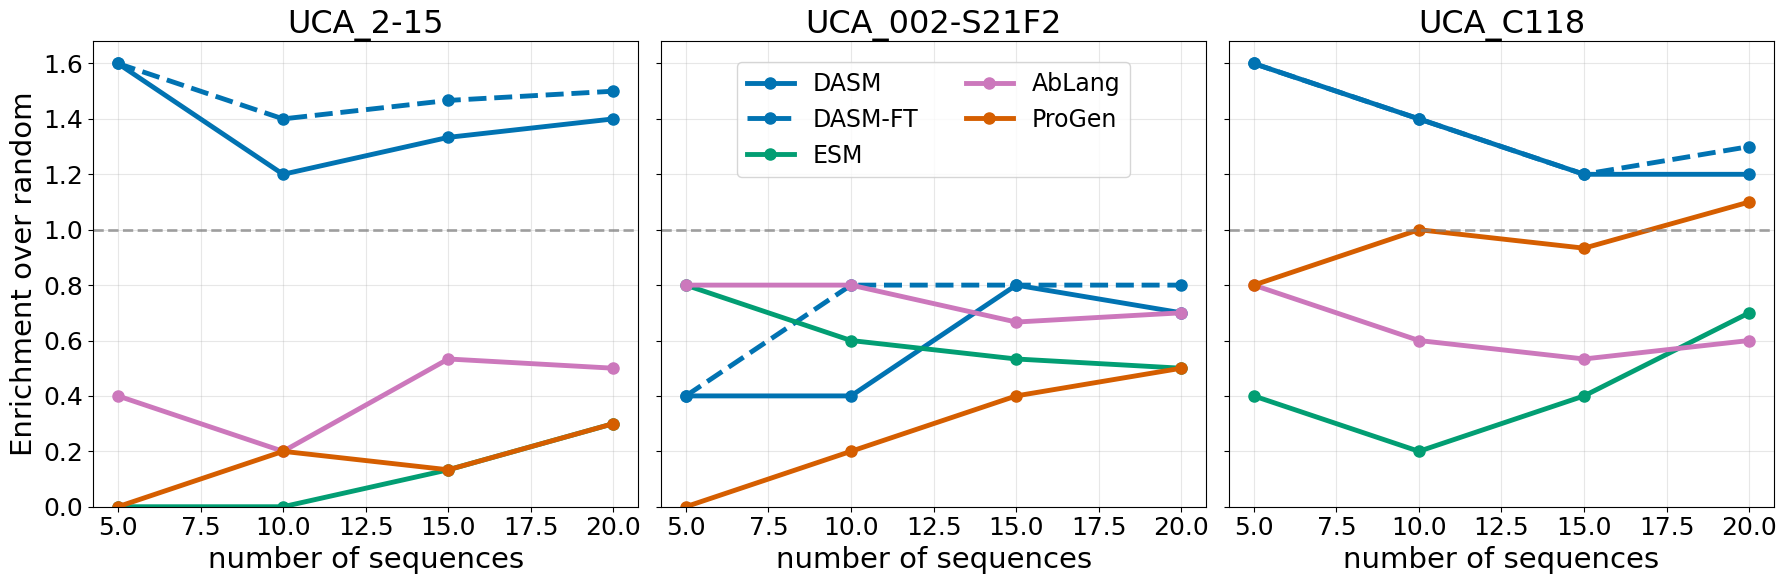


Enrichment over random selection by antibody:

UCA_2-15:
  DASM: top-5: 1.60x, top-10: 1.20x, top-15: 1.33x, top-20: 1.40x
  DASM_FT_MILD: top-5: 1.60x, top-10: 1.40x, top-15: 1.47x, top-20: 1.50x
  ESM: top-5: 0.00x, top-10: 0.00x, top-15: 0.13x, top-20: 0.30x
  ABLANG: top-5: 0.40x, top-10: 0.20x, top-15: 0.53x, top-20: 0.50x
  PROGEN: top-5: 0.00x, top-10: 0.20x, top-15: 0.13x, top-20: 0.30x

UCA_002-S21F2:
  DASM: top-5: 0.40x, top-10: 0.40x, top-15: 0.80x, top-20: 0.70x
  DASM_FT_MILD: top-5: 0.40x, top-10: 0.80x, top-15: 0.80x, top-20: 0.80x
  ESM: top-5: 0.80x, top-10: 0.60x, top-15: 0.53x, top-20: 0.50x
  ABLANG: top-5: 0.80x, top-10: 0.80x, top-15: 0.67x, top-20: 0.70x
  PROGEN: top-5: 0.00x, top-10: 0.20x, top-15: 0.40x, top-20: 0.50x

UCA_C118:
  DASM: top-5: 1.60x, top-10: 1.40x, top-15: 1.20x, top-20: 1.20x
  DASM_FT_MILD: top-5: 1.60x, top-10: 1.40x, top-15: 1.20x, top-20: 1.30x
  ESM: top-5: 0.40x, top-10: 0.20x, top-15: 0.40x, top-20: 0.70x
  ABLANG: top-5: 0.80x, top-

In [6]:
# Plot enrichment over random for all models
fig, axes = plt.subplots(1, len(antibodies), figsize=(18, 6), sharey=True)

# Increase base font size by 75%
base_font_size = 12
font_multiplier = 1.75
label_font_size = int(base_font_size * font_multiplier)
title_font_size = int(base_font_size * font_multiplier * 1.1)
tick_font_size = int(base_font_size * font_multiplier * 0.9)
legend_font_size = int(base_font_size * font_multiplier * 0.85)

for i, antibody in enumerate(antibodies):
    ax = axes[i]
    
    # Plot each model for this antibody
    for model in ['dasm', 'dasm_ft_mild', 'esm', 'ablang', 'progen']:
        # Get enrichment data for this antibody and model
        model_data = perf_df[(perf_df['antibody'] == antibody) & (perf_df['model'] == model)]
        if not model_data.empty:
            k_vals = model_data['k'].values
            enrich_vals = model_data['enrichment'].values
            
            # Use colors and linestyles
            color = colors.get(model, 'black')
            linestyle = linestyles.get(model, '-')
            
            # Fix legend labels
            if model == 'dasm_ft_mild':
                label = 'DASM-FT'
            elif model == 'ablang':
                label = 'AbLang'
            elif model == 'progen':
                label = 'ProGen'
            else:
                label = model.upper()
            
            # Plot line with increased thickness
            ax.plot(k_vals, enrich_vals, 'o-', color=color, linestyle=linestyle, 
                   linewidth=3.5, markersize=8, label=label)
    
    # Add horizontal line at y=1
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.7, linewidth=2)
    
    ax.set_xlabel('number of sequences', fontsize=label_font_size)
    if i == 0:  # Only set ylabel for the first subplot
        ax.set_ylabel('Enrichment over random', fontsize=label_font_size)
    ax.set_title(f'{antibody}', fontsize=title_font_size)
    ax.grid(True, alpha=0.3)
    
    # Increase tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    
    # Set y-axis to start at 0
    ax.set_ylim(bottom=0)
    
    # Add legend to the middle panel (i==1) at the top center
    if i == 1:
        ax.legend(fontsize=legend_font_size, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2)

plt.tight_layout()
plt.savefig(f"{figures_dir}/kirby_enrichment.svg", bbox_inches='tight')
plt.show()

# Print the enrichment values
print("\nEnrichment over random selection by antibody:")
for antibody in antibodies:
    print(f"\n{antibody}:")
    antibody_data = perf_df[perf_df['antibody'] == antibody]
    for model in models:
        model_data = antibody_data[antibody_data['model'] == model]
        if not model_data.empty:
            enrichments = model_data.set_index('k')['enrichment'].to_dict()
            enrichment_str = ', '.join([f"top-{k}: {v:.2f}x" for k, v in enrichments.items()])
            print(f"  {model.upper()}: {enrichment_str}")